# Instituto Tecnológico y de Estudios Superiores de Monterrey
## Maestría en Inteligencia Artificial Aplicada
### Proyecto Integrador (Gpo 10) - TC5035.10

### **Proyecto: Diseño Acelerado de Fármacos**

### Avance 4: Modelos alternativos

#### **Docentes:**
- Dra. Grettel Barceló Alonso - Profesor Titular
- Dr. Luis Eduardo Falcón Morales - Profesor Titular
- Dr. Horacio Martinez Alfaro  – Profesor Tutor

#### **Miembros del equipo:**
 - Jose Luis Artigas Arroyo - A01794906
 - José Luis Fabela Portillo - A00748551
 - Alejandro Emmanuel Silva Ortega - A01794545

In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import re
from sklearn.svm import SVC
import pickle
import joblib

In [167]:
#Define el path de los archivos necesarios
model_path = '../models/svc_model.pkl'
X_path = '../data/processed/DTCPep_pca_pfeatures.csv'
y_path = '../data/processed/DTCPep_y.csv'

In [168]:

baseline_model = joblib.load(model_path)
baseline_model

SVC(C=10, gamma=0.01, random_state=4)

In [169]:
X = pd.read_csv(X_path)
y = pd.read_csv(y_path)

# Separar datasets en train y test
Como primer paso separamos el dataset en entrenamiento (80%), prueba (16%) y validación (4%)

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state =42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state =4, stratify=y_train)

In [171]:
baseline_model.predict(X_test)

array([0, 0, 1, ..., 0, 0, 0], shape=(5177,))

In [172]:
# MODELS BUILDING AND PERFORMANCE EVALUATION

# Import required libraries for performance metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate
# Import required libraries for machine learning classifiers
from sklearn.linear_model import PassiveAggressiveClassifier, RidgeClassifierCV
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from scipy.stats import loguniform

In [173]:
# Define dictionary with performance metrics
scoring = {'accuracy':make_scorer(accuracy_score), 
           'precision':make_scorer(precision_score),
           'recall':make_scorer(recall_score), 
           'f1_score':make_scorer(f1_score)}

In [174]:
# Instantiate the machine learning classifiers
pac_model = PassiveAggressiveClassifier(n_jobs = -1, random_state= 4)
svc_model = LinearSVC(dual=False, random_state=4)
dtr_model = DecisionTreeClassifier(random_state=4)
rfc_model = RandomForestClassifier(n_jobs = -1, random_state= 4)
gnb_model = GaussianNB()
adaboost_model = AdaBoostClassifier(random_state=4)
ridge_model = RidgeClassifierCV()	

# Cross Validation

Se compararán los siguientes modelos con el modelo base trabajado en la actividad anterior:
- Passive Aggressive Classifier
- Linear SCV
- Decision Tree Classifier
- Random Forest Classifier
- Gaussian Naive Bayes
- AdaBoost
- Ridge CV

In [175]:
# Define the models evaluation function
def models_evaluation(baseline, X, y, folds):
    
    '''
    X : data set features
    y : data set target
    folds : number of cross-validation folds
    
    '''
    
    # Perform cross-validation to each machine learning classifier
    baseline = cross_validate(baseline, X, y, cv=folds, scoring=scoring) 
    pac = cross_validate(pac_model, X, y, cv=folds, scoring=scoring)
    svc = cross_validate(svc_model, X, y, cv=folds, scoring=scoring)
    dtr = cross_validate(dtr_model, X, y, cv=folds, scoring=scoring)
    rfc = cross_validate(rfc_model, X, y, cv=folds, scoring=scoring)
    gnb = cross_validate(gnb_model, X, y, cv=folds, scoring=scoring)
    adaboost = cross_validate(adaboost_model, X, y, cv=folds, scoring=scoring)
    ridge = cross_validate(ridge_model, X, y, cv=folds, scoring=scoring)

    # Create a data frame with the models perfoamnce measures scores
    models_scores_table = pd.DataFrame({'Base Model':[baseline['test_accuracy'].mean(),
                                                               baseline['test_precision'].mean(),
                                                               baseline['test_recall'].mean(),
                                                               baseline['test_f1_score'].mean()],
                                        'PasiveAgresiveClassifier':[pac['test_accuracy'].mean(),
                                                               pac['test_precision'].mean(),
                                                               pac['test_recall'].mean(),
                                                               pac['test_f1_score'].mean()],
                                       
                                      'Support Vector Classifier':[svc['test_accuracy'].mean(),
                                                                   svc['test_precision'].mean(),
                                                                   svc['test_recall'].mean(),
                                                                   svc['test_f1_score'].mean()],
                                       
                                      'Decision Tree':[dtr['test_accuracy'].mean(),
                                                       dtr['test_precision'].mean(),
                                                       dtr['test_recall'].mean(),
                                                       dtr['test_f1_score'].mean()],
                                       
                                      'Random Forest':[rfc['test_accuracy'].mean(),
                                                       rfc['test_precision'].mean(),
                                                       rfc['test_recall'].mean(),
                                                       rfc['test_f1_score'].mean()],
                                       
                                      'Gaussian Naive Bayes':[gnb['test_accuracy'].mean(),
                                                              gnb['test_precision'].mean(),
                                                              gnb['test_recall'].mean(),
                                                              gnb['test_f1_score'].mean()],
                                       
                                       'AdaBoost':[adaboost['test_accuracy'].mean(),
                                                              adaboost['test_precision'].mean(),
                                                              adaboost['test_recall'].mean(),
                                                              adaboost['test_f1_score'].mean()],
                                        
                                        'RidgeCV':[ridge['test_accuracy'].mean(),
                                                              ridge['test_precision'].mean(),
                                                              ridge['test_recall'].mean(),
                                                              ridge['test_f1_score'].mean()]},
                                      
                                      index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
    
    # Add 'Best Score' column
    models_scores_table['Best Score'] = models_scores_table.idxmax(axis=1)
    
    # Return models performance metrics scores data frame
    return(models_scores_table)

Cada uno de los modelos se analizará en primera instancia con una validación cruzada con 5 subconjuntos para cada modelo, con el objetivo de tener modelos más robustos y confiables, evitando el sobre entrenamiento.

In [176]:
# Run models_evaluation function
models_score = models_evaluation(baseline_model,X_train,y_train,5)
models_score

c:\Users\drjla\OneDrive\Desktop\MNA\proyecto\Advanced_drug_discovery\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\drjla\OneDrive\Desktop\MNA\proyecto\Advanced_drug_discovery\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\drjla\OneDrive\Desktop\MNA\proyecto\Advanced_drug_discovery\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\drjla\OneDrive\Desktop\MNA\proyecto\Advance

,Base Model,PasiveAgresiveClassifier,Support Vector Classifier,Decision Tree,Random Forest,Gaussian Naive Bayes,AdaBoost,RidgeCV,Best Score
Accuracy,0.811033,0.625153,0.709518,0.729606,0.805778,0.682477,0.715391,0.711835,Base Model
Precision,0.751370,0.413889,0.604728,0.582711,0.789030,0.511862,0.590797,0.619789,Random Forest
Recall,0.625393,0.455881,0.303666,0.587339,0.548292,0.484545,0.399802,0.291768,Base Model
F1 Score,0.682235,0.425317,0.403764,0.584955,0.646654,0.497272,0.475419,0.395989,Base Model


# Grid Search tunning 

## Random forest

In [177]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print(
                "Mean validation score: {0:.3f} (std: {1:.3f})".format(
                    results["mean_test_score"][candidate],
                    results["std_test_score"][candidate],
                )
            )
            print("Parameters: {0}".format(results["params"][candidate]))
            print("")


In [178]:
# Definir el diccionario de hiperparámetros
rf_params = dict( max_depth = np.linspace(10, 50, num=1).astype(int),
              n_estimators = np.linspace(100, 200, num=5).astype(int),
              criterion = ['entropy', 'log_loss'],
              max_features = ['sqrt', 'log2'],
              class_weight = ['balanced', 'balanced_subsample']
              
)

# Configurar RandomizedSearchCV
n_iter_search = 15
rfc_random_search = RandomizedSearchCV(
    rfc_model, param_distributions=rf_params, n_iter=n_iter_search, n_jobs= -1, verbose=3, scoring = scoring, refit = 'precision'
)

# Ajustar el modelo
rfc_random_search.fit(X_train,y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


c:\Users\drjla\OneDrive\Desktop\MNA\proyecto\Advanced_drug_discovery\.venv\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomizedSearchCV(estimator=RandomForestClassifier(n_jobs=-1, random_state=4),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'class_weight': ['balanced',
                                                         'balanced_subsample'],
                                        'criterion': ['entropy', 'log_loss'],
                                        'max_depth': array([10]),
                                        'max_features': ['sqrt', 'log2'],
                                        'n_estimators': array([100, 125, 150, 175, 200])},
                   refit='precision',
                   scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                            'f1_score': make_scorer(f1_score, response_method='predict'),
                            'precision': make_scorer(precision_score, response_method='predict'),
                            'recall': make_scorer(recall_score, response_method='predict')},
                   verbose=3)

In [179]:
# Mejor estimador encontrado
rfc_random_search.best_estimator_

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=np.int64(10), n_estimators=np.int64(125),
                       n_jobs=-1, random_state=4)

In [180]:
rfc_random_search.scorer_

{'accuracy': make_scorer(accuracy_score, response_method='predict'),
 'precision': make_scorer(precision_score, response_method='predict'),
 'recall': make_scorer(recall_score, response_method='predict'),
 'f1_score': make_scorer(f1_score, response_method='predict')}

In [181]:
# Predice valores de y
y_predict_rfc_train = rfc_random_search.predict(X_train)
y_predict_rfc_val = rfc_random_search.predict(X_val)
y_predict_rfc_test = rfc_random_search.predict(X_test)

# Calcula la precisión
accuracy_rfc_train = accuracy_score(y_train,y_predict_rfc_train)
accuracy_rfc_val = accuracy_score(y_val,y_predict_rfc_val)
accuracy_rfc_test = accuracy_score(y_test,y_predict_rfc_test)

print(f'Accuracy train {accuracy_rfc_train}')
print(f'Accuracy val {accuracy_rfc_val}')
print(f'Accuracy test {accuracy_rfc_test}')


Accuracy train 0.8640296662546354
Accuracy val 0.8625482625482626
Accuracy test 0.8644002317944756


In [182]:
# Scores
print(classification_report(y_train, y_predict_rfc_train, target_names=['positive','negative']))
print(classification_report(y_val, y_predict_rfc_val, target_names=['positive','negative']))
print(classification_report(y_test, y_predict_rfc_test, target_names=['positive','negative']))

              precision    recall  f1-score   support

    positive       0.94      0.86      0.89      4371
    negative       0.75      0.88      0.81      2101

    accuracy                           0.86      6472
   macro avg       0.84      0.87      0.85      6472
weighted avg       0.87      0.86      0.87      6472

              precision    recall  f1-score   support

    positive       0.94      0.85      0.89       875
    negative       0.74      0.89      0.81       420

    accuracy                           0.86      1295
   macro avg       0.84      0.87      0.85      1295
weighted avg       0.88      0.86      0.87      1295

              precision    recall  f1-score   support

    positive       0.93      0.86      0.90      3496
    negative       0.75      0.87      0.81      1681

    accuracy                           0.86      5177
   macro avg       0.84      0.87      0.85      5177
weighted avg       0.87      0.86      0.87      5177



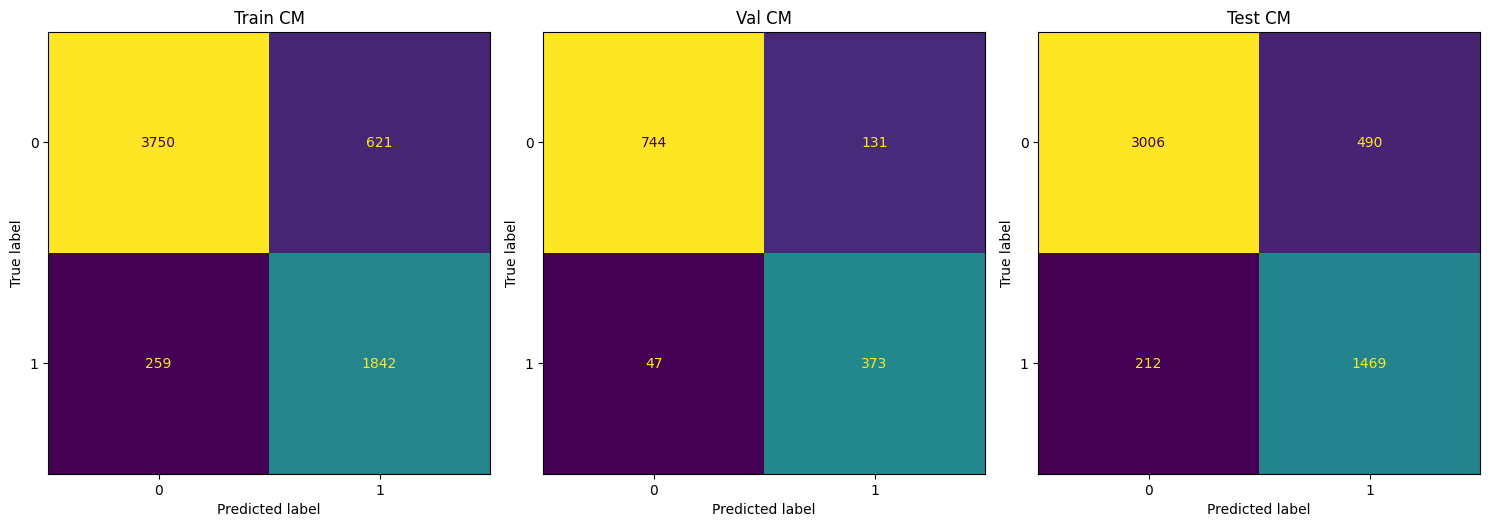

In [183]:
# Crear figuras y ejes
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 fila, 3 columnas

# Matriz de confusión para el conjunto de entrenamiento
cm_rf_train = confusion_matrix(y_train, y_predict_rfc_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf_train)
disp.plot(ax=axes[0], colorbar=False)
axes[0].set_title('Train CM')

# Matriz de confusión para el conjunto de validación
cm_rf_val = confusion_matrix(y_val, y_predict_rfc_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf_val)
disp.plot(ax=axes[1], colorbar=False)
axes[1].set_title('Val CM')

# Matriz de confusión para el conjunto de prueba
cm_rf_test = confusion_matrix(y_test, y_predict_rfc_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf_test)
disp.plot(ax=axes[2], colorbar=False)
axes[2].set_title('Test CM')

# Ajustar el espacio entre los gráficos
plt.tight_layout()
plt.show()


In [236]:
rfc_random_search

RandomizedSearchCV(estimator=RandomForestClassifier(n_jobs=-1, random_state=4),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'class_weight': ['balanced',
                                                         'balanced_subsample'],
                                        'criterion': ['entropy', 'log_loss'],
                                        'max_depth': array([10]),
                                        'max_features': ['sqrt', 'log2'],
                                        'n_estimators': array([100, 125, 150, 175, 200])},
                   refit='precision',
                   scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                            'f1_score': make_scorer(f1_score, response_method='predict'),
                            'precision': make_scorer(precision_score, response_method='predict'),
                            'recall': make_scorer(recall_score, response_method='predict')},
                   verbose=3)

In [239]:
cross_validate(rfc_random_search, X, y, cv=5, scoring=scoring)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


c:\Users\drjla\OneDrive\Desktop\MNA\proyecto\Advanced_drug_discovery\.venv\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 5 folds for each of 15 candidates, totalling 75 fits


c:\Users\drjla\OneDrive\Desktop\MNA\proyecto\Advanced_drug_discovery\.venv\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 5 folds for each of 15 candidates, totalling 75 fits


c:\Users\drjla\OneDrive\Desktop\MNA\proyecto\Advanced_drug_discovery\.venv\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 5 folds for each of 15 candidates, totalling 75 fits


c:\Users\drjla\OneDrive\Desktop\MNA\proyecto\Advanced_drug_discovery\.venv\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 5 folds for each of 15 candidates, totalling 75 fits


c:\Users\drjla\OneDrive\Desktop\MNA\proyecto\Advanced_drug_discovery\.venv\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


{'fit_time': array([265.68871689, 244.92912316, 298.10921335, 243.71214604,
        248.5828228 ]),
 'score_time': array([0.19542456, 0.14918303, 0.14565039, 0.19784379, 0.18481922]),
 'test_accuracy': array([0.69363805, 0.64833127, 0.62793572, 0.77688504, 0.73300371]),
 'test_precision': array([0.52952756, 0.46085409, 0.45518044, 0.66141732, 0.56601124]),
 'test_recall': array([0.51140684, 0.49333333, 0.7447619 , 0.64      , 0.7661597 ]),
 'test_f1_score': array([0.52030948, 0.47654094, 0.5650289 , 0.65053243, 0.65105008])}

In [184]:
with open("../models/rf_model.pkl", "wb") as f:
    pickle.dump(rfc_random_search.best_estimator_, f)
print("Random Forest Model saved")

Random Forest Model saved


## Decision Tree

In [185]:
# Definir el diccionario de hiperparámetros
dtr_params = dict(
    max_depth=np.linspace(10, 50, num=5).astype(int),   # Profundidad máxima del árbol
    criterion=['gini', 'entropy'],                     # Criterio para medir la calidad de una división
    splitter=['best', 'random'],                       # Estrategia utilizada para elegir la división en cada nodo
    min_samples_split=[2, 5, 10],                      # Número mínimo de muestras requeridas para dividir un nodo interno
    min_samples_leaf=[1, 2, 4])          

# Configurar RandomizedSearchCV
n_iter_search = 15
dtr_random_search = RandomizedSearchCV(
    dtr_model, 
    param_distributions=dtr_params, 
    n_iter=n_iter_search, 
    n_jobs= -1, 
    verbose=3, 
    scoring = scoring, 
    refit = 'precision')

# Ajustar el modelo
dtr_random_search.fit(X_train,y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=4), n_iter=15,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([10, 20, 30, 40, 50]),
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'splitter': ['best', 'random']},
                   refit='precision',
                   scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                            'f1_score': make_scorer(f1_score, response_method='predict'),
                            'precision': make_scorer(precision_score, response_method='predict'),
                            'recall': make_scorer(recall_score, response_method='predict')},
                   verbose=3)

In [186]:
# Mejor estimador encontrado
dtr_random_search.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=np.int64(10),
                       min_samples_leaf=2, min_samples_split=10,
                       random_state=4)

In [187]:
dtr_random_search.scorer_

{'accuracy': make_scorer(accuracy_score, response_method='predict'),
 'precision': make_scorer(precision_score, response_method='predict'),
 'recall': make_scorer(recall_score, response_method='predict'),
 'f1_score': make_scorer(f1_score, response_method='predict')}

In [188]:
# Predice valores de y
y_predict_dtr_train = dtr_random_search.predict(X_train)
y_predict_dtr_val = dtr_random_search.predict(X_val)
y_predict_dtr_test = dtr_random_search.predict(X_test)

# Calcula la precisión
accuracy_dtr_train = accuracy_score(y_train,y_predict_dtr_train)
accuracy_dtr_val = accuracy_score(y_val,y_predict_dtr_val)
accuracy_dtr_test = accuracy_score(y_test,y_predict_dtr_test)

print(f'Accuracy train {accuracy_dtr_train}')
print(f'Accuracy val {accuracy_dtr_val}')
print(f'Accuracy test {accuracy_dtr_test}')

Accuracy train 0.8216934487021014
Accuracy val 0.8231660231660232
Accuracy test 0.8213250917519799


In [189]:
# Scores
print(classification_report(y_train, y_predict_dtr_train, target_names=['positive','negative']))
print(classification_report(y_val, y_predict_dtr_val, target_names=['positive','negative']))
print(classification_report(y_test, y_predict_dtr_test, target_names=['positive','negative']))

              precision    recall  f1-score   support

    positive       0.86      0.87      0.87      4371
    negative       0.73      0.71      0.72      2101

    accuracy                           0.82      6472
   macro avg       0.80      0.79      0.80      6472
weighted avg       0.82      0.82      0.82      6472

              precision    recall  f1-score   support

    positive       0.87      0.87      0.87       875
    negative       0.73      0.72      0.73       420

    accuracy                           0.82      1295
   macro avg       0.80      0.80      0.80      1295
weighted avg       0.82      0.82      0.82      1295

              precision    recall  f1-score   support

    positive       0.86      0.87      0.87      3496
    negative       0.73      0.71      0.72      1681

    accuracy                           0.82      5177
   macro avg       0.80      0.79      0.79      5177
weighted avg       0.82      0.82      0.82      5177



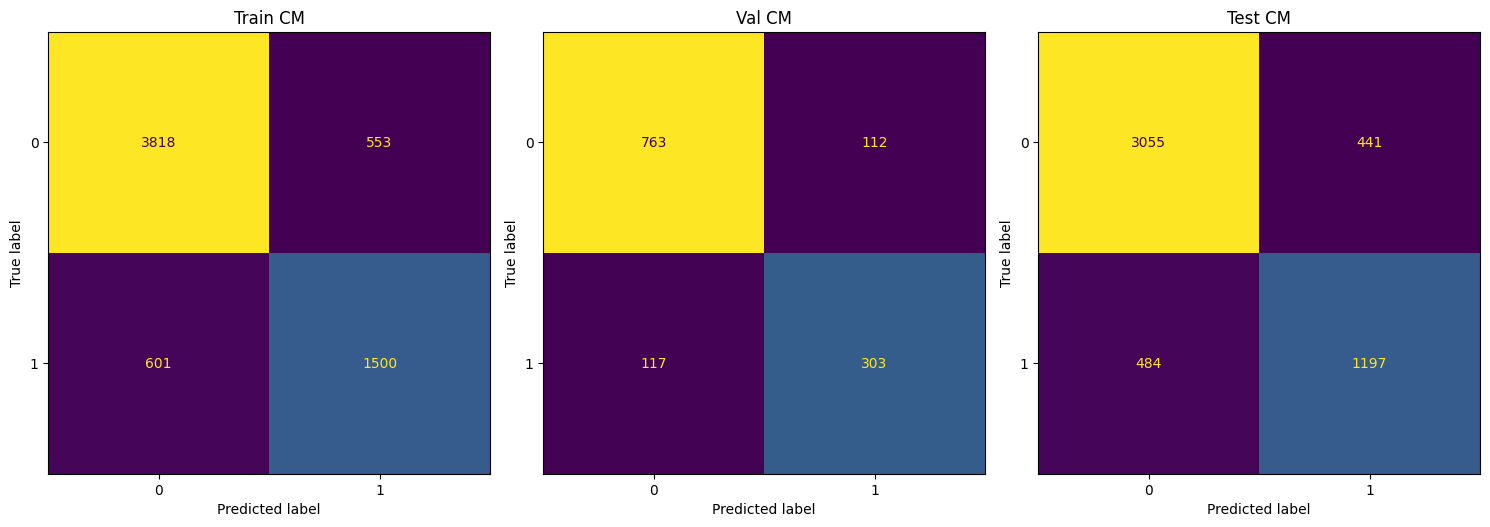

In [190]:
# Crear figuras y ejes
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 fila, 3 columnas

# Matriz de confusión para el conjunto de entrenamiento
cm_dtr_train = confusion_matrix(y_train, y_predict_dtr_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dtr_train)
disp.plot(ax=axes[0], colorbar=False)
axes[0].set_title('Train CM')

# Matriz de confusión para el conjunto de validación
cm_dtr_val = confusion_matrix(y_val, y_predict_dtr_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dtr_val)
disp.plot(ax=axes[1], colorbar=False)
axes[1].set_title('Val CM')

# Matriz de confusión para el conjunto de prueba
cm_dtr_test = confusion_matrix(y_test, y_predict_dtr_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dtr_test)
disp.plot(ax=axes[2], colorbar=False)
axes[2].set_title('Test CM')

# Ajustar el espacio entre los gráficos
plt.tight_layout()
plt.show()

In [191]:
with open("../models/dtr_model.pkl", "wb") as f:
    pickle.dump(dtr_random_search.best_estimator_, f)
print("Decision Tree Model saved")

Decision Tree Model saved


## Linear Support Vector Classifier

In [192]:
# Definir el diccionario de hiperparámetros
# La salida arroja observaciones debido a que algunas combinaciones de los hiperparámetros no son válidas.
linear_svc_params = dict(
    C=[0.1, 1, 10, 100],              # Parámetro de regularización
    penalty=['l1', 'l2'],              # Tipo de penalización (solo 'l2' está soportado por defecto)
    loss=['hinge', 'squared_hinge'],   # Función de pérdida
    dual=[False, True],                # Estrategia de resolución dual o primal
    max_iter=[1000, 2000, 3000]        # Número máximo de iteraciones
)

# Configurar RandomizedSearchCV
n_iter_search = 15
svc_random_search = RandomizedSearchCV(
    svc_model, 
    param_distributions=linear_svc_params, 
    n_iter=n_iter_search, 
    n_jobs=-1, 
    verbose=3, 
    scoring=scoring, 
    refit='precision'
)

# Ajustar el modelo
svc_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


c:\Users\drjla\OneDrive\Desktop\MNA\proyecto\Advanced_drug_discovery\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
30 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\drjla\OneDrive\Desktop\MNA\proyecto\Advanced_drug_discovery\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\drjla\OneDrive\Desktop\MNA\proyecto\Advanced_drug_discovery\.venv\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^

RandomizedSearchCV(estimator=LinearSVC(dual=False, random_state=4), n_iter=15,
                   n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'dual': [False, True],
                                        'loss': ['hinge', 'squared_hinge'],
                                        'max_iter': [1000, 2000, 3000],
                                        'penalty': ['l1', 'l2']},
                   refit='precision',
                   scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                            'f1_score': make_scorer(f1_score, response_method='predict'),
                            'precision': make_scorer(precision_score, response_method='predict'),
                            'recall': make_scorer(recall_score, response_method='predict')},
                   verbose=3)

In [193]:
# Mejor estimador encontrado
svc_random_search.best_estimator_

LinearSVC(C=10, dual=True, loss='hinge', max_iter=2000, random_state=4)

In [194]:
svc_random_search.scorer_

{'accuracy': make_scorer(accuracy_score, response_method='predict'),
 'precision': make_scorer(precision_score, response_method='predict'),
 'recall': make_scorer(recall_score, response_method='predict'),
 'f1_score': make_scorer(f1_score, response_method='predict')}

In [195]:
# Predice valores de y
y_predict_svc_train = svc_random_search.predict(X_train)
y_predict_svc_val = svc_random_search.predict(X_val)
y_predict_svc_test = svc_random_search.predict(X_test)

# Calcula la precisión:
accuracy_svc_train = accuracy_score(y_train,y_predict_svc_train)
accuracy_svc_val = accuracy_score(y_val,y_predict_svc_val)
accuracy_svc_test = accuracy_score(y_test,y_predict_svc_test)

print(f'Accuracy train {accuracy_svc_train}')
print(f'Accuracy val {accuracy_svc_val}')
print(f'Accuracy test {accuracy_svc_test}')


Accuracy train 0.7048825710754018
Accuracy val 0.7034749034749035
Accuracy test 0.7052346919065096


In [196]:
# Scores
print(classification_report(y_train, y_predict_svc_train, target_names=['positive','negative']))
print(classification_report(y_val, y_predict_svc_val, target_names=['positive','negative']))
print(classification_report(y_test, y_predict_svc_test, target_names=['positive','negative']))

              precision    recall  f1-score   support

    positive       0.73      0.91      0.81      4371
    negative       0.59      0.29      0.39      2101

    accuracy                           0.70      6472
   macro avg       0.66      0.60      0.60      6472
weighted avg       0.68      0.70      0.67      6472

              precision    recall  f1-score   support

    positive       0.73      0.90      0.80       875
    negative       0.58      0.30      0.39       420

    accuracy                           0.70      1295
   macro avg       0.66      0.60      0.60      1295
weighted avg       0.68      0.70      0.67      1295

              precision    recall  f1-score   support

    positive       0.72      0.91      0.81      3496
    negative       0.60      0.28      0.38      1681

    accuracy                           0.71      5177
   macro avg       0.66      0.60      0.60      5177
weighted avg       0.68      0.71      0.67      5177



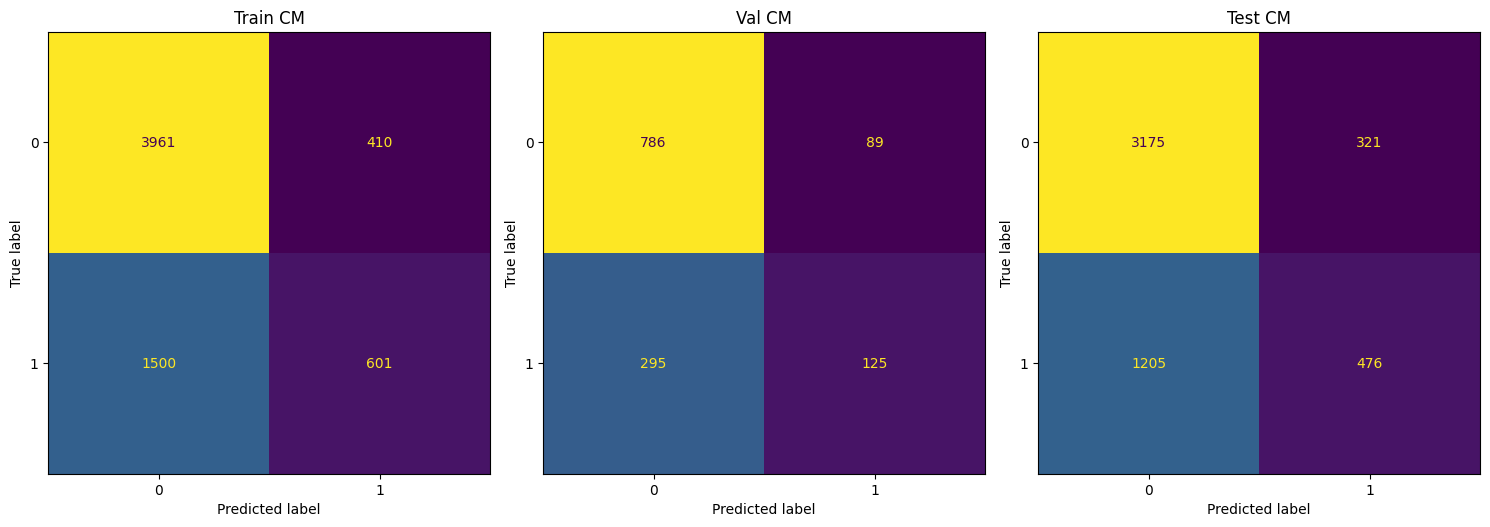

In [197]:
# Crear figuras y ejes
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 fila, 3 columnas

# Matriz de confusión para el conjunto de entrenamiento
cm_svc_train = confusion_matrix(y_train, y_predict_svc_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svc_train)
disp.plot(ax=axes[0], colorbar=False)
axes[0].set_title('Train CM')

# Matriz de confusión para el conjunto de validación
cm_svc_val = confusion_matrix(y_val, y_predict_svc_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svc_val)
disp.plot(ax=axes[1], colorbar=False)
axes[1].set_title('Val CM')

# Matriz de confusión para el conjunto de prueba
cm_svc_test = confusion_matrix(y_test, y_predict_svc_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svc_test)
disp.plot(ax=axes[2], colorbar=False)
axes[2].set_title('Test CM')

# Ajustar el espacio entre los gráficos
plt.tight_layout()
plt.show()

In [198]:
with open("../models/lsvc_model.pkl", "wb") as f:
    pickle.dump(svc_random_search.best_estimator_, f)
print("Linear Support Vector Classifier Model saved")

Linear Support Vector Classifier Model saved


## Pasive Agresive Classifier

In [199]:
# Definir el diccionario de hiperparámetros
pac_params = dict(
    C=[0.1, 1, 10, 100],                     # Parámetro de regularización
    max_iter=[1000, 2000, 3000],              # Número máximo de iteraciones
    tol=[1e-3, 1e-4, 1e-5],                   # Tolerancia para la optimización
    loss=['hinge', 'squared_hinge'],          # Función de pérdida
    early_stopping=[True, False],             # Si se usa o no el parón temprano
    validation_fraction=[0.1, 0.2, 0.3],      # Fracción de datos usados para la validación cuando se usa el parón temprano
    n_iter_no_change=[5, 10, 15]              # Número de iteraciones con ninguna mejora para el parón temprano
)

# Configurar RandomizedSearchCV
n_iter_search = 15
pac_random_search = RandomizedSearchCV(
    pac_model, 
    param_distributions=pac_params, 
    n_iter=n_iter_search, 
    n_jobs=-1, 
    verbose=3, 
    scoring=scoring, 
    refit='precision'
)

# Ajustar el modelo
pac_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


c:\Users\drjla\OneDrive\Desktop\MNA\proyecto\Advanced_drug_discovery\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(estimator=PassiveAggressiveClassifier(n_jobs=-1,
                                                         random_state=4),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'early_stopping': [True, False],
                                        'loss': ['hinge', 'squared_hinge'],
                                        'max_iter': [1000, 2000, 3000],
                                        'n_iter_no_change': [5, 10, 15],
                                        'tol': [0.001, 0.0001, 1e-05],
                                        'validation_fraction': [0.1, 0.2, 0.3]},
                   refit='precision',
                   scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                            'f1_score': make_scorer(f1_score, response_method='predict'),
                            'precision': make_scorer(precision_score, response_method='predict'),
                            'recall': make_scorer(recall_score, response_method='predict')},
                   verbose=3)

In [200]:
# Mejor estimador encontrado
pac_random_search.best_estimator_

PassiveAggressiveClassifier(C=10, max_iter=3000, n_iter_no_change=15, n_jobs=-1,
                            random_state=4, tol=1e-05, validation_fraction=0.2)

In [201]:
pac_random_search.scorer_

{'accuracy': make_scorer(accuracy_score, response_method='predict'),
 'precision': make_scorer(precision_score, response_method='predict'),
 'recall': make_scorer(recall_score, response_method='predict'),
 'f1_score': make_scorer(f1_score, response_method='predict')}

In [202]:
# Predice valores de y
y_predict_pac_train = pac_random_search.predict(X_train)
y_predict_pac_val = pac_random_search.predict(X_val)
y_predict_pac_test = pac_random_search.predict(X_test)

# Calcula la precisión:
accuracy_pac_train = accuracy_score(y_train,y_predict_pac_train)
accuracy_pac_val = accuracy_score(y_val,y_predict_pac_val)
accuracy_pac_test = accuracy_score(y_test,y_predict_pac_test)

print(f'Accuracy train {accuracy_pac_train}')
print(f'Accuracy val {accuracy_pac_val}')
print(f'Accuracy test {accuracy_pac_test}')

Accuracy train 0.6336526576019778
Accuracy val 0.6293436293436293
Accuracy test 0.6347305389221557


In [203]:
# Scores
print(classification_report(y_train, y_predict_pac_train, target_names=['positive','negative']))
print(classification_report(y_val, y_predict_pac_val, target_names=['positive','negative']))
print(classification_report(y_test, y_predict_pac_test, target_names=['positive','negative']))

              precision    recall  f1-score   support

    positive       0.69      0.84      0.76      4371
    negative       0.38      0.20      0.26      2101

    accuracy                           0.63      6472
   macro avg       0.53      0.52      0.51      6472
weighted avg       0.59      0.63      0.60      6472

              precision    recall  f1-score   support

    positive       0.68      0.84      0.75       875
    negative       0.37      0.20      0.25       420

    accuracy                           0.63      1295
   macro avg       0.53      0.52      0.50      1295
weighted avg       0.58      0.63      0.59      1295

              precision    recall  f1-score   support

    positive       0.69      0.84      0.76      3496
    negative       0.38      0.20      0.26      1681

    accuracy                           0.63      5177
   macro avg       0.53      0.52      0.51      5177
weighted avg       0.59      0.63      0.60      5177



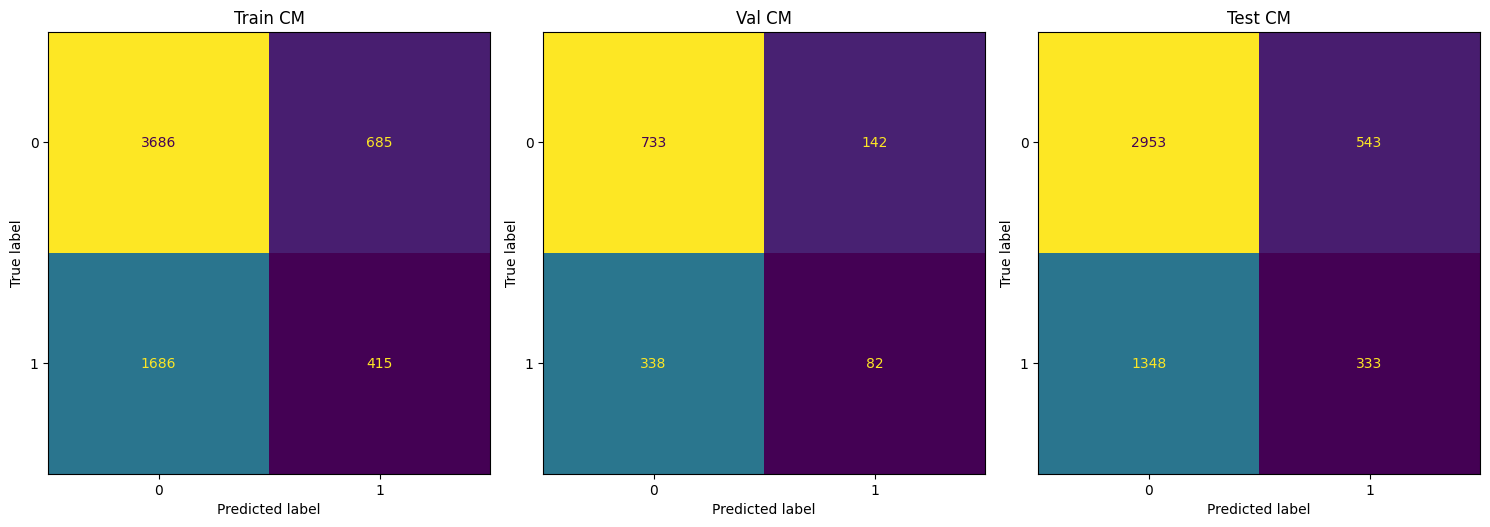

In [204]:
# Crear figuras y ejes
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 fila, 3 columnas

# Matriz de confusión para el conjunto de entrenamiento
cm_pac_train = confusion_matrix(y_train, y_predict_pac_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_pac_train)
disp.plot(ax=axes[0], colorbar=False)
axes[0].set_title('Train CM')

# Matriz de confusión para el conjunto de validación
cm_pac_val = confusion_matrix(y_val, y_predict_pac_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_pac_val)
disp.plot(ax=axes[1], colorbar=False)
axes[1].set_title('Val CM')

# Matriz de confusión para el conjunto de prueba
cm_pac_test = confusion_matrix(y_test, y_predict_pac_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_pac_test)
disp.plot(ax=axes[2], colorbar=False)
axes[2].set_title('Test CM')

# Ajustar el espacio entre los gráficos
plt.tight_layout()
plt.show()

In [205]:
with open("../models/pac_model.pkl", "wb") as f:
    pickle.dump(pac_random_search.best_estimator_, f)
print("Pasive Agresive Classifier Model saved")

Pasive Agresive Classifier Model saved


## Gaussian Naive Bayes

In [206]:
# Definir el diccionario de hiperparámetros
gnb_params = dict(
    var_smoothing=np.logspace(0, -9, num=100)  # Espacio de búsqueda en escala logarítmica
)

# Configurar RandomizedSearchCV
n_iter_search = 15
gnb_random_search = RandomizedSearchCV(
    gnb_model, 
    param_distributions=gnb_params, 
    n_iter=n_iter_search, 
    n_jobs=-1, 
    verbose=3, 
    scoring=scoring, 
    refit='precision'
)

# Ajustar el modelo
gnb_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


c:\Users\drjla\OneDrive\Desktop\MNA\proyecto\Advanced_drug_discovery\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(estimator=GaussianNB(), n_iter=15, n_jobs=-1,
                   param_distributions={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51...
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
                   refit='precision',
                   scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                            'f1_score': make_scorer(f1_score, response_method='predict'),
                            'precision': make_scorer(precision_score, response_method='predict'),
                            'recall': make_scorer(recall_score, response_method='predict')},
                   verbose=3)

In [207]:
# Mejor estimador encontrado
gnb_random_search.best_estimator_

GaussianNB(var_smoothing=np.float64(0.8111308307896871))

In [208]:
gnb_random_search.scorer_

{'accuracy': make_scorer(accuracy_score, response_method='predict'),
 'precision': make_scorer(precision_score, response_method='predict'),
 'recall': make_scorer(recall_score, response_method='predict'),
 'f1_score': make_scorer(f1_score, response_method='predict')}

In [209]:
# Predice valores de y
y_predict_gnb_train = gnb_random_search.predict(X_train)
y_predict_gnb_val = gnb_random_search.predict(X_val)
y_predict_gnb_test = gnb_random_search.predict(X_test)

# Calcula la precisión:
accuracy_gnb_train = accuracy_score(y_train,y_predict_gnb_train)
accuracy_gnb_val = accuracy_score(y_val,y_predict_gnb_val)
accuracy_gnb_test = accuracy_score(y_test,y_predict_gnb_test)

print(f'Accuracy train {accuracy_gnb_train}')
print(f'Accuracy val {accuracy_gnb_val}')
print(f'Accuracy test {accuracy_gnb_test}')

Accuracy train 0.6796971569839307
Accuracy val 0.6803088803088803
Accuracy test 0.6795441375313889


In [210]:
# Scores
print(classification_report(y_train, y_predict_gnb_train, target_names=['positive','negative']))
print(classification_report(y_val, y_predict_gnb_val, target_names=['positive','negative']))
print(classification_report(y_test, y_predict_gnb_test, target_names=['positive','negative']))

              precision    recall  f1-score   support

    positive       0.68      1.00      0.81      4371
    negative       0.73      0.02      0.04      2101

    accuracy                           0.68      6472
   macro avg       0.71      0.51      0.42      6472
weighted avg       0.70      0.68      0.56      6472

              precision    recall  f1-score   support

    positive       0.68      1.00      0.81       875
    negative       0.88      0.02      0.03       420

    accuracy                           0.68      1295
   macro avg       0.78      0.51      0.42      1295
weighted avg       0.74      0.68      0.56      1295

              precision    recall  f1-score   support

    positive       0.68      1.00      0.81      3496
    negative       0.71      0.02      0.04      1681

    accuracy                           0.68      5177
   macro avg       0.70      0.51      0.43      5177
weighted avg       0.69      0.68      0.56      5177



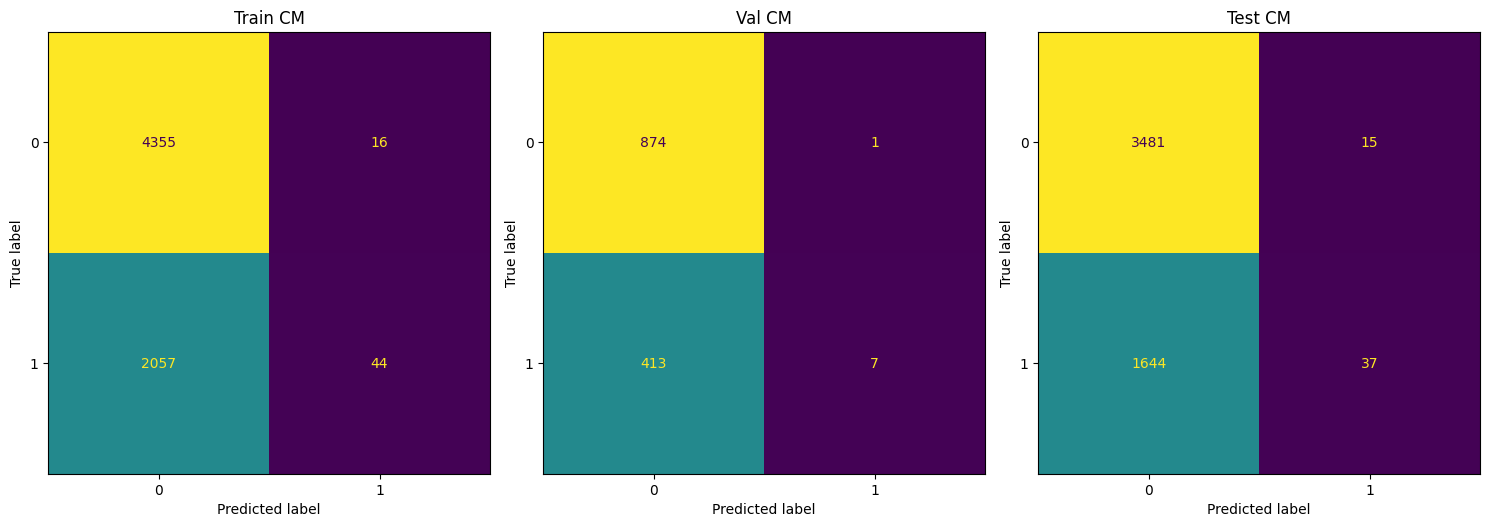

In [211]:
# Crear figuras y ejes
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 fila, 3 columnas

# Matriz de confusión para el conjunto de entrenamiento
cm_gnb_train = confusion_matrix(y_train, y_predict_gnb_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_gnb_train)
disp.plot(ax=axes[0], colorbar=False)
axes[0].set_title('Train CM')

# Matriz de confusión para el conjunto de validación
cm_gnb_val = confusion_matrix(y_val, y_predict_gnb_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_gnb_val)
disp.plot(ax=axes[1], colorbar=False)
axes[1].set_title('Val CM')

# Matriz de confusión para el conjunto de prueba
cm_gnb_test = confusion_matrix(y_test, y_predict_gnb_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_gnb_test)
disp.plot(ax=axes[2], colorbar=False)
axes[2].set_title('Test CM')

# Ajustar el espacio entre los gráficos
plt.tight_layout()
plt.show()

In [212]:
with open("../models/gnb_model.pkl", "wb") as f:
    pickle.dump(gnb_random_search.best_estimator_, f)
print("Gaussian Naive Bayes Model saved")

Gaussian Naive Bayes Model saved


## AdaBoost

In [213]:
# Definir el diccionario de hiperparámetros
ada_params = dict(
    n_estimators=[50, 100, 200, 300],                # Número de árboles base
    learning_rate=[0.01, 0.1, 1, 10],                # Tasa de aprendizaje
)

# Configurar RandomizedSearchCV
n_iter_search = 15
ada_random_search = RandomizedSearchCV(
    adaboost_model, 
    param_distributions=ada_params, 
    n_iter=n_iter_search, 
    n_jobs=-1, 
    verbose=3, 
    scoring=scoring, 
    refit='precision'
)

# Ajustar el modelo
ada_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


c:\Users\drjla\OneDrive\Desktop\MNA\proyecto\Advanced_drug_discovery\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(estimator=AdaBoostClassifier(random_state=4), n_iter=15,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.1, 1, 10],
                                        'n_estimators': [50, 100, 200, 300]},
                   refit='precision',
                   scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                            'f1_score': make_scorer(f1_score, response_method='predict'),
                            'precision': make_scorer(precision_score, response_method='predict'),
                            'recall': make_scorer(recall_score, response_method='predict')},
                   verbose=3)

In [214]:
# Mejor estimador encontrado
ada_random_search.best_estimator_

AdaBoostClassifier(learning_rate=0.1, n_estimators=100, random_state=4)

In [215]:
ada_random_search.scorer_

{'accuracy': make_scorer(accuracy_score, response_method='predict'),
 'precision': make_scorer(precision_score, response_method='predict'),
 'recall': make_scorer(recall_score, response_method='predict'),
 'f1_score': make_scorer(f1_score, response_method='predict')}

In [216]:
# Predice valores de y
y_predict_ada_train = ada_random_search.predict(X_train)
y_predict_ada_val = ada_random_search.predict(X_val)
y_predict_ada_test = ada_random_search.predict(X_test)

# Calcula la precisión:
accuracy_ada_train = accuracy_score(y_train,y_predict_ada_train)
accuracy_ada_val = accuracy_score(y_val,y_predict_ada_val)
accuracy_ada_test = accuracy_score(y_test,y_predict_ada_test)

print(f'Accuracy train {accuracy_ada_train}')
print(f'Accuracy val {accuracy_ada_val}')
print(f'Accuracy test {accuracy_ada_test}')

Accuracy train 0.7022558714462299
Accuracy val 0.7081081081081081
Accuracy test 0.7007919644581804


In [217]:
# Scores
print(classification_report(y_train, y_predict_ada_train, target_names=['positive','negative']))
print(classification_report(y_val, y_predict_ada_val, target_names=['positive','negative']))
print(classification_report(y_test, y_predict_ada_test, target_names=['positive','negative']))

              precision    recall  f1-score   support

    positive       0.70      0.98      0.82      4371
    negative       0.74      0.13      0.22      2101

    accuracy                           0.70      6472
   macro avg       0.72      0.55      0.52      6472
weighted avg       0.71      0.70      0.62      6472

              precision    recall  f1-score   support

    positive       0.70      0.98      0.82       875
    negative       0.80      0.13      0.23       420

    accuracy                           0.71      1295
   macro avg       0.75      0.56      0.52      1295
weighted avg       0.73      0.71      0.63      1295

              precision    recall  f1-score   support

    positive       0.70      0.98      0.82      3496
    negative       0.73      0.13      0.21      1681

    accuracy                           0.70      5177
   macro avg       0.71      0.55      0.52      5177
weighted avg       0.71      0.70      0.62      5177



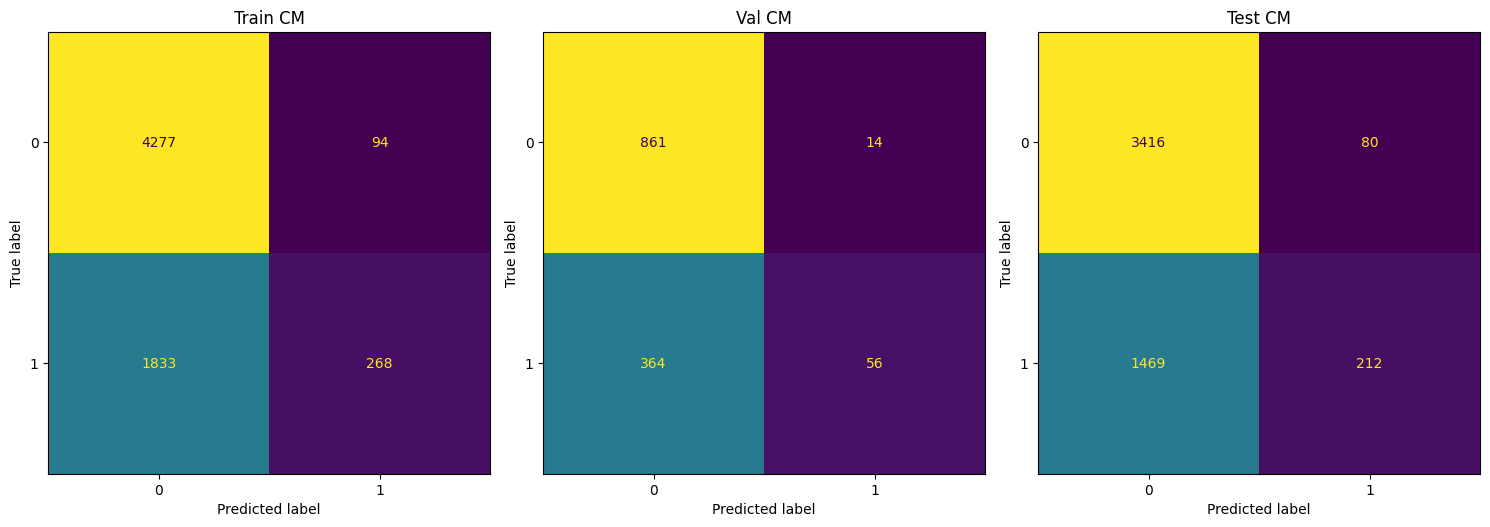

In [218]:
# Crear figuras y ejes
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 fila, 3 columnas

# Matriz de confusión para el conjunto de entrenamiento
cm_ada_train = confusion_matrix(y_train, y_predict_ada_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ada_train)
disp.plot(ax=axes[0], colorbar=False)
axes[0].set_title('Train CM')

# Matriz de confusión para el conjunto de validación
cm_ada_val = confusion_matrix(y_val, y_predict_ada_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ada_val)
disp.plot(ax=axes[1], colorbar=False)
axes[1].set_title('Val CM')

# Matriz de confusión para el conjunto de prueba
cm_ada_test = confusion_matrix(y_test, y_predict_ada_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ada_test)
disp.plot(ax=axes[2], colorbar=False)
axes[2].set_title('Test CM')

# Ajustar el espacio entre los gráficos
plt.tight_layout()
plt.show()

In [219]:
with open("../models/ada_model.pkl", "wb") as f:
    pickle.dump(ada_random_search.best_estimator_, f)
print("AdaBoost Model saved")

AdaBoost Model saved


## Ridge CV Model

In [220]:
# Definir el diccionario de hiperparámetros
ridge_params = dict(
    alphas=np.logspace(-6, 6, 13),      # Valores de alpha en una escala logarítmica
    fit_intercept=[True, False],       # Si se ajusta el intercepto
)

# Configurar RandomizedSearchCV
n_iter_search = 15
ridge_random_search = RandomizedSearchCV(
    ridge_model, 
    param_distributions=ridge_params, 
    n_iter=n_iter_search, 
    n_jobs=-1, 
    verbose=3, 
    scoring=scoring, 
    refit='precision'
)

# Ajustar el modelo
ridge_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


c:\Users\drjla\OneDrive\Desktop\MNA\proyecto\Advanced_drug_discovery\.venv\Lib\site-packages\sklearn\linear_model\_ridge.py:1307: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(estimator=RidgeClassifierCV(), n_iter=15, n_jobs=-1,
                   param_distributions={'alphas': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06]),
                                        'fit_intercept': [True, False]},
                   refit='precision',
                   scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                            'f1_score': make_scorer(f1_score, response_method='predict'),
                            'precision': make_scorer(precision_score, response_method='predict'),
                            'recall': make_scorer(recall_score, response_method='predict')},
                   verbose=3)

In [221]:
# Mejor estimador encontrado
ridge_random_search.best_estimator_

RidgeClassifierCV(alphas=np.float64(0.01))

In [222]:
ridge_random_search.scorer_

{'accuracy': make_scorer(accuracy_score, response_method='predict'),
 'precision': make_scorer(precision_score, response_method='predict'),
 'recall': make_scorer(recall_score, response_method='predict'),
 'f1_score': make_scorer(f1_score, response_method='predict')}

In [223]:
# Predice valores de y
y_predict_ridge_train = ridge_random_search.predict(X_train)
y_predict_ridge_val = ridge_random_search.predict(X_val)
y_predict_ridge_test = ridge_random_search.predict(X_test)

# Calcula la precisión:
accuracy_ridge_train = accuracy_score(y_train,y_predict_ridge_train)
accuracy_ridge_val = accuracy_score(y_val,y_predict_ridge_val)
accuracy_ridge_test = accuracy_score(y_test,y_predict_ridge_test)

print(f'Accuracy train {accuracy_ridge_train}')
print(f'Accuracy val {accuracy_ridge_val}')
print(f'Accuracy test {accuracy_ridge_test}')

Accuracy train 0.7124536464771323
Accuracy val 0.7158301158301158
Accuracy test 0.711609039984547


In [224]:
# Scores
print(classification_report(y_train, y_predict_ridge_train, target_names=['positive','negative']))
print(classification_report(y_val, y_predict_ridge_val, target_names=['positive','negative']))
print(classification_report(y_test, y_predict_ridge_test, target_names=['positive','negative']))

              precision    recall  f1-score   support

    positive       0.73      0.91      0.81      4371
    negative       0.62      0.30      0.40      2101

    accuracy                           0.71      6472
   macro avg       0.67      0.60      0.61      6472
weighted avg       0.69      0.71      0.68      6472

              precision    recall  f1-score   support

    positive       0.73      0.91      0.81       875
    negative       0.63      0.31      0.41       420

    accuracy                           0.72      1295
   macro avg       0.68      0.61      0.61      1295
weighted avg       0.70      0.72      0.68      1295

              precision    recall  f1-score   support

    positive       0.73      0.91      0.81      3496
    negative       0.62      0.29      0.40      1681

    accuracy                           0.71      5177
   macro avg       0.67      0.60      0.60      5177
weighted avg       0.69      0.71      0.68      5177



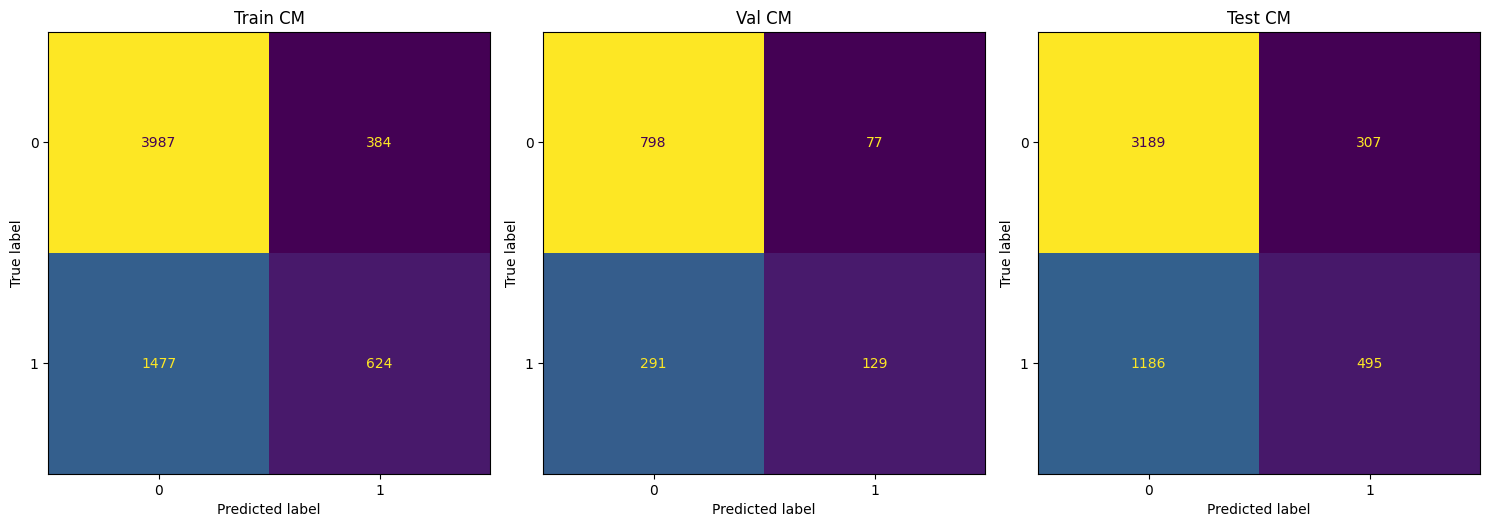

In [225]:
# Crear figuras y ejes
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 fila, 3 columnas

# Matriz de confusión para el conjunto de entrenamiento
cm_ridge_train = confusion_matrix(y_train, y_predict_ridge_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ridge_train)
disp.plot(ax=axes[0], colorbar=False)
axes[0].set_title('Train CM')

# Matriz de confusión para el conjunto de validación
cm_ridge_val = confusion_matrix(y_val, y_predict_ridge_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ridge_val)
disp.plot(ax=axes[1], colorbar=False)
axes[1].set_title('Val CM')

# Matriz de confusión para el conjunto de prueba
cm_ridge_test = confusion_matrix(y_test, y_predict_ridge_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ridge_test)
disp.plot(ax=axes[2], colorbar=False)
axes[2].set_title('Test CM')

# Ajustar el espacio entre los gráficos
plt.tight_layout()
plt.show()

In [226]:
with open("../models/ridge_model.pkl", "wb") as f:
    pickle.dump(ridge_random_search.best_estimator_, f)
print("Ridge CV Model saved")

Ridge CV Model saved


## Comparación de modelos

In [233]:
# Create a data frame with the models perfoamnce measures scores
modelos_gridsearch = pd.DataFrame({'Base Model' : models_score['Base Model'],
    
    'PasiveAgresiveClassifier':[accuracy_score(y_train,y_predict_pac_train),
                            precision_score(y_train,y_predict_pac_train),
                            recall_score(y_train,y_predict_pac_train),
                            f1_score(y_train,y_predict_pac_train)],
    
    'Support Vector Classifier':[accuracy_score(y_train,y_predict_svc_train),
                            precision_score(y_train,y_predict_svc_train),
                            recall_score(y_train,y_predict_svc_train),
                            f1_score(y_train,y_predict_svc_train)],
    
    'Decision Tree':[accuracy_score(y_train,y_predict_dtr_train),
                            precision_score(y_train,y_predict_dtr_train),
                            recall_score(y_train,y_predict_dtr_train),
                            f1_score(y_train,y_predict_dtr_train)],
    
    'Random Forest':[accuracy_score(y_train,y_predict_rfc_train),
                            precision_score(y_train,y_predict_rfc_train),
                            recall_score(y_train,y_predict_rfc_train),
                            f1_score(y_train,y_predict_rfc_train)],
    
    'Gaussian Naive Bayes':[accuracy_score(y_train,y_predict_gnb_train),
                            precision_score(y_train,y_predict_gnb_train),
                            recall_score(y_train,y_predict_gnb_train),
                            f1_score(y_train,y_predict_gnb_train)],
    
    'AdaBoost':[accuracy_score(y_train,y_predict_ada_train),
                            precision_score(y_train,y_predict_ada_train),
                            recall_score(y_train,y_predict_ada_train),
                            f1_score(y_train,y_predict_ada_train)],
    
    'RidgeCV':[accuracy_score(y_train,y_predict_ridge_train),
                            precision_score(y_train,y_predict_ridge_train),
                            recall_score(y_train,y_predict_ridge_train),
                            f1_score(y_train,y_predict_ridge_train)],
    },
    
    index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])

modelos_gridsearch['Best Score'] = modelos_gridsearch.iloc[:, 1:].idxmax(axis=1)

In [235]:
print('Resultados de los modelos con Grid Search Tunning')
modelos_gridsearch

Resultados de los modelos con Grid Search Tunning


,Base Model,PasiveAgresiveClassifier,Support Vector Classifier,Decision Tree,Random Forest,Gaussian Naive Bayes,AdaBoost,RidgeCV,Best Score
Accuracy,0.811033,0.633653,0.704883,0.821693,0.864030,0.679697,0.702256,0.712454,Random Forest
Precision,0.751370,0.377273,0.594461,0.730638,0.747868,0.733333,0.740331,0.619048,Random Forest
Recall,0.625393,0.197525,0.286054,0.713946,0.876725,0.020942,0.127558,0.297001,Random Forest
F1 Score,0.682235,0.259294,0.386247,0.722195,0.807187,0.040722,0.217621,0.401415,Random Forest


In [232]:
print('Resultados de los modelos con Cross Validation')
models_score

Resultados de los modelos con Cross Validation


,Base Model,PasiveAgresiveClassifier,Support Vector Classifier,Decision Tree,Random Forest,Gaussian Naive Bayes,AdaBoost,RidgeCV,Best Score
Accuracy,0.811033,0.625153,0.709518,0.729606,0.805778,0.682477,0.715391,0.711835,Base Model
Precision,0.751370,0.413889,0.604728,0.582711,0.789030,0.511862,0.590797,0.619789,Random Forest
Recall,0.625393,0.455881,0.303666,0.587339,0.548292,0.484545,0.399802,0.291768,Base Model
F1 Score,0.682235,0.425317,0.403764,0.584955,0.646654,0.497272,0.475419,0.395989,Base Model
